## 05.소프트맥스 회귀로 MNIST 데이터 분류하기

이번 챕터에서는 MNIST 데이터에 대해서 이해하고, 파이토치(PyTorch)로 소프트맥스 회귀를 구현하여 MNIST 데이터를 분류하는 실습을 진행해보자.

MNIST 데이터는 아래의 링크에 공개되어져 있다.

링크 : http://yann.lecun.com/exdb/mnist

### 1.MNIST 데이터 이해하기

<img src = 'https://wikidocs.net/images/page/60324/mnist.png' width = 60%>

MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋이다. 이 데이터는 과거에 우체국에서 편지의 우편 번호를 인식하기 위해서 만들어진 훈련 데이터이다. 총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어져 있다. 레이블은 0부터 9까지 총 10개이다. 이 예제는 머신러닝을 처음 배울 때 접하게 되는 가장 기본적인 예제이기도 하다.

MNIST 문제는 손글씨로 적힌 숫자 이미지가 들어오면, 그 이미지가 무슨 숫자인지 맞추는 문제이다. 예를 들어 숫자 5의 이미지가 입력으로 들어오면 이게 숫자 5다! 라는 것을 맞춰야 한다. 이 문제는 사람에게는 굉장히 간단하지만 기계에게는 그렇지가 않다.

우선 MNIST 문제를 더 자세히 보겠다. 각각의 이미지는 아래와 같이 28 픽셀 x 28 픽셀의 이미지이다.

<img src = 'https://wikidocs.net/images/page/60324/mnist_SVbcYYG.png' width = 60%>

이 문제를 풀기 위해 여기서는 28 픽셀 x 28 픽셀 = 784 픽셀이므로, 각 이미지를 총 784의 원소를 가진 벡터로 만들어줄것이다. 이렇게 되면 총 784개의 특성을 가진 샘플이 되는데, 이는 앞서 우리가 풀었던 그 어떤 문제들보다 특성이 굉장히 많은 샘플이다.

<img src = 'https://wikidocs.net/images/page/60324/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C.png' width = 60%>

784차원의 벡터로 만드는 코드를 미리보기로 보면 아래와 같다.

``` python
for X, Y in data_loader:
  # 입력 이미지를 [batch_size × 784]의 크기로 reshape
  # 레이블은 원-핫 인코딩
  X = X.view(-1, 28*28)
```

위의 코드에서 X는 for문에서 호출될 때는 (배치 크기 x 1 x 28 x 28)의 크기를 가지지만, view를 통해서 (배치 크기 x 784)의 크기로 변환된다.





### 2.토치비전(torchvision) 소개하기

본격적인 실습에 들어가기에 앞서 토치비전(torchvision)이라는 도구를 설명하겠다. torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지이다. 아래의 링크는 torchvision에 어떤 데이터셋들(datasets)과 모델들(models) 그리고 어떤 전처리 방법들(transforms)을 제공하고 있는지 보여준다.

링크 : https://pytorch.org/docs/stable/torchvision/index.html

* **자연어 처리를 위해서는 토치텍스트(torchtext)라는 패키지가 있다.**

### 3.분류기 구현을 위한 사전 설정

우선 필요한 도구들을 임포트한다.

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import random

현재 환경에서 GPU 연산이 가능하다면 GPU 연산을 하고, 그렇지 않다면 CPU 연산을 하도록 한다.



In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴

device = torch.device('cuda' if USE_CUDA else 'cpu') # GPU 사용가능하면 사용하고 아니면 CPU 사용

print('다음 기기로 학습합니다:', device)

다음 기기로 학습합니다: cpu


구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나온다. 즉, GPU로 연산하겠다는 의미이다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나온다. 즉, CPU로 연산하겠다는 의미이다.

위의 방법은 앞으로 자주 쓰이게 되므로 기억해두자.

랜덤 시드를 고정한다.

In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

하이퍼파라미터를 변수로 둔다.


In [4]:
# hyperparameters
training_epochs = 15
batch_size = 100

### 4.MNIST 분류기 구현하기

torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있다.

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)
mnist_test = dsets.MNIST(root = 'MNIST_data/',
                         train = False,
                         transform = transforms.ToTensor(),
                         download = True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로이다. 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받는다. 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해준다. 네번째 인자 download는 해당 경로에 MNIST 데이터가 없으면 다운로드 받겠다는 의미이다.

이렇게 데이터를 다운로드했다면 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더(DataLoader)를 사용한다.



In [6]:
# dataset loader
data_loader = DataLoader(dataset = mnist_train,
                         batch_size = batch_size, # 배치 크기는 100
                         shuffle = True,
                         drop_last = True)


이때 DataLoader에는 4개의 인자가 있다. 첫번째 인자인 DataLoader는 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미한다.

* **drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해보자. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남는다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있다. 이때 마지막 배치를 버리려면 drop_last = True를 해주면 된다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아준다.**

이제 모델을 설계한다. input_dim은 784이고, output_dim은 10이다.



In [7]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias = True).to(device)

to() 함수는 연산을 어디서 수행할지를 정한다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보낸다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 된다.

bias는 편향 b를 사용할 것인지를 나타낸다. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었다.

이제 비용 함수와 옵티마이저를 정의한다.

In [8]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음. 
optimizer = torch.optim.SGD(linear.parameters(), lr = 0.1)

* **앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()를 사용하고 있다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있다.**

In [9]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.

    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')



Epoch: 0001 cost = 0.534912467
Epoch: 0002 cost = 0.359308660
Epoch: 0003 cost = 0.331088185
Epoch: 0004 cost = 0.316574216
Epoch: 0005 cost = 0.307130307
Epoch: 0006 cost = 0.300207913
Epoch: 0007 cost = 0.294897258
Epoch: 0008 cost = 0.290830404
Epoch: 0009 cost = 0.287419617
Epoch: 0010 cost = 0.284588993
Epoch: 0011 cost = 0.281816244
Epoch: 0012 cost = 0.279919654
Epoch: 0013 cost = 0.277836859
Epoch: 0014 cost = 0.276022345
Epoch: 0015 cost = 0.274443209
Learning finished


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.8867999911308289
Label:  5
Prediction:  3


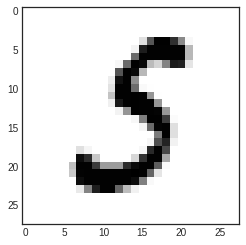

In [11]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.

    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
    

참고 자료 :
https://excelsior-cjh.tistory.com/180

torch.nn.functional과 torch.nn의 차이 :

https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597